|model |accuracy|
|----|:-----:|
|ResNet50+Xception+InceptionV3 | o.967|
|Xception+InceptionV3 | o.967|
|ResNet50+Xception | 0.961|
|ResNet50+InceptionV3 | o.962|
|CNN model | 0.879 |

##  <font color='red'>Please upvote if you found this useful :)</font>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
import random

import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")

from sklearn.model_selection import train_test_split

In [ ]:
Images_path = "../input/plant-pathology-2020-fgvc7/images/"

In [ ]:
train_df = pd.read_csv("../input/plant-pathology-2020-fgvc7/train.csv")
test_df = pd.read_csv("../input/plant-pathology-2020-fgvc7/test.csv")
sample_submission_df = pd.read_csv("../input/plant-pathology-2020-fgvc7/sample_submission.csv")

In [ ]:
print("train_df.shape : ",train_df.shape)
print("test_df.shape : ",test_df.shape)
print("sample_submission_df.shape : ",sample_submission_df.shape)

In [ ]:
sample_image = cv2.imread(Images_path+"Train_0.jpg")
print("sample Image shape : ",sample_image.shape)
# sample_image = cv2.resize(sample_image, (512,256))
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image)
plt.axis("off")
plt.show()

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
sample_submission_df.head()

In [ ]:
train_df['image_id'] = train_df['image_id'].apply(lambda x: x+'.jpg')
test_df['image_id'] = test_df['image_id'].apply(lambda x: x+'.jpg')

In [ ]:
train_df.columns[1:5]

In [ ]:
image_shape_x1,image_shape_x2 = (400,400)

In [ ]:
train_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                                    vertical_flip=True,
                                                                    rotation_range=10,
                                                                    width_shift_range=0.1,
                                                                    height_shift_range=0.1,
                                                                    zoom_range=.1,
                                                                    fill_mode='nearest',
                                                                    shear_range=0.1,
                                                                    rescale=1/255,
                                                                    brightness_range=[0.5, 1.5],
                                                                    validation_split=0.15)

train_image_flow_dataframe = train_image_datagen.flow_from_dataframe(dataframe = train_df,
                                                        directory = Images_path,
                                                        x_col = 'image_id',
                                                        y_col = train_df.columns[1:5],
                                                        subset="training",
                                                        batch_size=32,
                                                        shuffle=False,
                                                        class_mode="raw",
                                                        target_size=(image_shape_x1,image_shape_x2)
                                                        )

validation_image_flow_dataframe = train_image_datagen.flow_from_dataframe(dataframe = train_df,
                                                        directory = Images_path,
                                                        x_col = 'image_id',
                                                        y_col = train_df.columns[1:5],
                                                        subset="validation",
                                                        batch_size=32,
                                                        shuffle=False,
                                                        class_mode="raw",
                                                        target_size=(image_shape_x1,image_shape_x2)
                                                        )

In [ ]:
test_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

test_image_flow_dataframe = test_image_datagen.flow_from_dataframe(dataframe = test_df,
                                                                   directory = Images_path,
                                                                   x_col = 'image_id',
                                                                   y_col = None,
                                                                   batch_size=32,
                                                                   shuffle= False,
                                                                   class_mode= None,
                                                                   target_size=(image_shape_x1,image_shape_x2)
                                                                  )

In [ ]:
train_input , train_output = next(train_image_flow_dataframe)

print("train input shape(batchwise) : ",train_input.shape)
print("train output shape(batchwise) : ",train_output.shape)

validation_input , validation_output = next(validation_image_flow_dataframe)

print("validation input shape(batchwise) : ",validation_input.shape)
print("validation output shape(batchwise) : ",validation_output.shape)

test_input = next(test_image_flow_dataframe)

print("test input shape(batchwise) : ",test_input.shape)

In [ ]:
# Visulize Batch

def show_batch(input_data, output_data):
    fig, ax = plt.subplots(nrows=input_data.shape[0]//4, ncols=4,figsize=(20,20))
    plt.axis('off')
    label = ['healthy', 'multiple_diseases', 'rust', 'scab']
    for i in range(input_data.shape[0]):
        ax[i//4,i%4].imshow(input_data[i])
        ax[i//4,i%4].axis('off')
        ax[i//4,i%4].set_title([p for p,q in zip(label,list(output_data[i])) if q==1][0])
    plt.show()

In [ ]:
# Train Batch 
show_batch(train_input, train_output)

In [ ]:
# model Building

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(256,kernel_size=5,padding='same',strides=2,input_shape=[256,512,3]))
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv2D(256,kernel_size=5,strides=2))
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Conv2D(512,kernel_size=5,strides=2))
model.add(tf.keras.layers.ReLU())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(4,activation='softmax'))

model.compile(tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy",'mean_squared_error'])

model.summary()

In [ ]:
LR_START = 0.0001
LR_MAX = 0.005 
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(20)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
STEP_SIZE_TRAIN=train_image_flow_dataframe.n//train_image_flow_dataframe.batch_size 
STEP_SIZE_VALID=validation_image_flow_dataframe.n//validation_image_flow_dataframe.batch_size 
STEP_SIZE_TEST=test_image_flow_dataframe.n//test_image_flow_dataframe.batch_size 

print("STEP_SIZE_TRAIN",STEP_SIZE_TRAIN)
print("STEP_SIZE_VALID",STEP_SIZE_VALID)
print("STEP_SIZE_TEST",STEP_SIZE_TEST)

In [ ]:
H = model.fit_generator(generator=train_image_flow_dataframe,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_image_flow_dataframe,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20)

In [ ]:
loss, acc = model.evaluate_generator(generator=validation_image_flow_dataframe,steps=STEP_SIZE_VALID,verbose=1)

In [ ]:
plt.plot(H.history['loss'], label='MAE (testing data)')
plt.plot(H.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
model.save("basic_model")

In [ ]:
pred_basic = model.predict_generator(test_image_flow_dataframe,verbose=1)

In [ ]:
sample_submission_df.loc[:,'healthy':] = pred_basic
sample_submission_df.to_csv('pred_basic_model.csv', index=False)
sample_submission_df.head()

## Transfer Learning

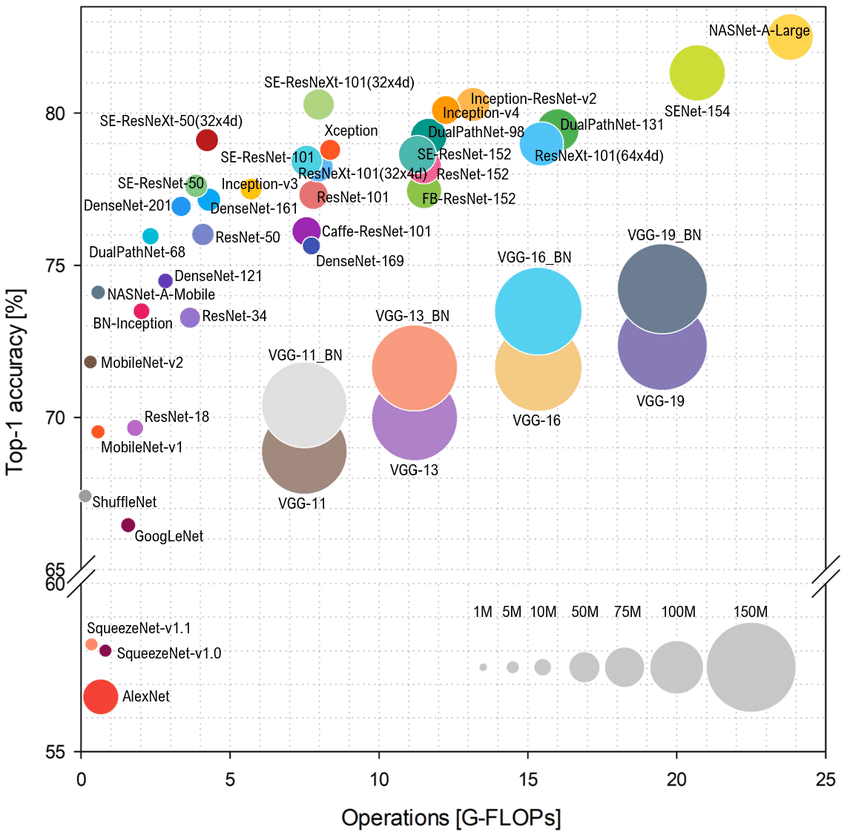

You always want to go for the smallest model that works well for your data. Up until earlier this year, people usually start with VGG16 or VGG19, but Resnet is also a great choice for fine tuning. Start with Resnet18, then to Resnet34 and Resnet50. You could also try the newer models in ResNext or Nascent nets.

Bigger models is not always better. They usually overfit your train data. What you really care about is Validation loss. Keeping it small, yet closer to training loss is tricky and may need some regularization like DropOut or WeightDecay etc.

When working on a new problem, always start with simple networks - Resnet18 / 34 or 50 are good choices.

In [ ]:
# base models

def get_base_model(model_name):
    
    if model_name == "ResNet50":
        base_model = tf.keras.applications.ResNet50(weights="imagenet",
                                                    input_shape = (image_shape_x1,image_shape_x2,3),
                                                    include_top=False)
        
    if model_name == "ResNet101":
        base_model = tf.keras.applications.ResNet101(weights="imagenet",
                                                    input_shape = (image_shape_x1,image_shape_x2,3),
                                                    include_top=False)
        
    if model_name == "ResNet152":
        base_model = tf.keras.applications.ResNet152(weights="imagenet",
                                                    input_shape = (image_shape_x1,image_shape_x2,3),
                                                    include_top=False)
    
    if model_name == "DenseNet121":
        base_model = tf.keras.applications.DenseNet121(weights="imagenet",
                                                    input_shape = (image_shape_x1,image_shape_x2,3),
                                                    include_top=False)
        
    if model_name == "DenseNet169":
        base_model = tf.keras.applications.DenseNet169(weights="imagenet",
                                                    input_shape = (image_shape_x1,image_shape_x2,3),
                                                    include_top=False)
        
    if model_name == "DenseNet201":
        base_model = tf.keras.applications.DenseNet201(weights="imagenet",
                                                    input_shape = (image_shape_x1,image_shape_x2,3),
                                                    include_top=False)
        
    if model_name == "MobileNet":
        base_model = tf.keras.applications.MobileNet(weights="imagenet",
                                                    input_shape = (image_shape_x1,image_shape_x2,3),
                                                    include_top=False)
    
    if model_name == "VGG19":
        base_model = tf.keras.applications.VGG19(weights="imagenet",
                                                    input_shape = (image_shape_x1,image_shape_x2,3),
                                                    include_top=False)
    
    if model_name == "Xception":
        base_model = tf.keras.applications.Xception(weights="imagenet",
                                                    input_shape = (image_shape_x1,image_shape_x2,3),
                                                    include_top=False)
    
    if model_name == "InceptionV3":
        base_model = tf.keras.applications.InceptionV3(weights="imagenet",
                                                    input_shape = (image_shape_x1,image_shape_x2,3),
                                                    include_top=False)
    
    return base_model

In [ ]:
def get_model_info(model):
    print("Number of layer in model : ",len(model.layers))

    trainable_count = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_count = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

    print('Total params: {:,}'.format(trainable_count + non_trainable_count))
    print('Trainable params: {:,}'.format(trainable_count))
    print('Non-trainable params: {:,}'.format(non_trainable_count))
    
    num_trainable_layer = np.sum([1 for layer in model.layers if layer.trainable])
    print("Total trainable layers : ",num_trainable_layer)

## ResNet50

In [ ]:
base_model_ResNet50 = get_base_model("ResNet50")

In [ ]:
# Befor Fine Tune
get_model_info(base_model_ResNet50)

In [ ]:
base_model_ResNet50.trainable = True
# all layers are trainable
# fine_tune = np.floor(len(base_model_ResNet50.layers)*0.1)
for layer in base_model_ResNet50.layers:
    layer.trainable =  True

In [ ]:
# After Fine Tune
get_model_info(base_model_ResNet50)

In [ ]:
model_ResNet50 = tf.keras.models.Sequential()

model_ResNet50.add(base_model_ResNet50)

model_ResNet50.add(tf.keras.layers.GlobalAveragePooling2D())

model_ResNet50.add(tf.keras.layers.Dense(128))
model_ResNet50.add(tf.keras.layers.ReLU())

model_ResNet50.add(tf.keras.layers.Dense(64))
model_ResNet50.add(tf.keras.layers.ReLU())

model_ResNet50.add(tf.keras.layers.Dense(4,activation='softmax'))

model_ResNet50.compile(optimizer="adam",
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=['categorical_accuracy'])

model_ResNet50.summary()

In [ ]:
# After adding FC layers
get_model_info(model_ResNet50)

In [ ]:
reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", 
                                                  factor = 0.3, 
                                                  patience = 3,
                                                  verbose = 1,
                                                  min_lr = 1e-6)

In [ ]:
H_ResNet50 =  model_ResNet50.fit_generator(train_image_flow_dataframe, 
                     validation_data=validation_image_flow_dataframe,
                     steps_per_epoch = STEP_SIZE_TRAIN,
                     validation_steps=STEP_SIZE_VALID, 
                     epochs = 30, 
                     verbose = 1,
                     callbacks = [reduce_lr],
                     shuffle=True)

In [ ]:
loss, acc = model_ResNet50.evaluate_generator(generator=validation_image_flow_dataframe,steps=STEP_SIZE_VALID,verbose=1)

In [ ]:
plt.plot(H_ResNet50.history['loss'], label='MAE (testing data)')
plt.plot(H_ResNet50.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
pred_ResNet50 = model_ResNet50.predict(test_image_flow_dataframe,verbose=1)

In [ ]:
sample_submission_df.loc[:,'healthy':] = pred_ResNet50
sample_submission_df.to_csv('Submission_ResNet50.csv', index=False)
sample_submission_df.head()

In [ ]:
model_ResNet50.save("model_ResNet50")

## Xception

In [ ]:
base_model_Xception = get_base_model("Xception")

In [ ]:
get_model_info(base_model_Xception)

In [ ]:
base_model_Xception.trainable = True
# all layers are trainable
# fine_tune = np.floor(len(base_model_Xception.layers)*0.1)
for layer in base_model_Xception.layers:
    layer.trainable =  True

In [ ]:
model_Xception = tf.keras.models.Sequential()

model_Xception.add(base_model_Xception)

model_Xception.add(tf.keras.layers.GlobalAveragePooling2D())

model_Xception.add(tf.keras.layers.Dense(4,activation='softmax'))

model_Xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False),
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=['categorical_accuracy'])

model_Xception.summary()

In [ ]:
reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", 
                                                  factor = 0.3, 
                                                  patience = 3,
                                                  verbose = 1,
                                                  min_lr = 1e-6)

In [ ]:
H_Xception =  model_Xception.fit_generator(train_image_flow_dataframe, 
                     validation_data=validation_image_flow_dataframe,
                     steps_per_epoch = STEP_SIZE_TRAIN,
                     validation_steps=STEP_SIZE_VALID, 
                     epochs = 30, 
                     verbose = 1,
                     callbacks = [reduce_lr],
                     shuffle=True)

In [ ]:
loss, acc = model_Xception.evaluate_generator(generator=validation_image_flow_dataframe,steps=STEP_SIZE_VALID,verbose=1)

In [ ]:
plt.plot(H_Xception.history['loss'], label='MAE (testing data)')
plt.plot(H_Xception.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
pred_Xception = model_Xception.predict(test_image_flow_dataframe,verbose=1)

In [ ]:
sample_submission_df.loc[:,'healthy':] = pred_Xception
sample_submission_df.to_csv('model_Xception.csv', index=False)
sample_submission_df.head()

In [ ]:
model_Xception.save("model_Xception")

## InceptionV3


In [ ]:
base_model_InceptionV3 = get_base_model("InceptionV3")

In [ ]:
get_model_info(base_model_InceptionV3)

In [ ]:
base_model_InceptionV3.trainable = True
# all layers are trainable
# fine_tune = np.floor(len(base_model_InceptionV3.layers)*0.1)
for layer in base_model_InceptionV3.layers:
    layer.trainable =  True

In [ ]:
model_InceptionV3 = tf.keras.models.Sequential()

model_InceptionV3.add(base_model_InceptionV3)

model_InceptionV3.add(tf.keras.layers.GlobalAveragePooling2D())

model_InceptionV3.add(tf.keras.layers.Dense(4,activation='softmax'))

model_InceptionV3.compile(optimizer="adam",
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=['categorical_accuracy'])

model_InceptionV3.summary()

In [ ]:
reduce_lr =  tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", 
                                                  factor = 0.3, 
                                                  patience = 3,
                                                  verbose = 1,
                                                  min_lr = 1e-6)

In [ ]:
H_InceptionV3 =  model_InceptionV3.fit_generator(train_image_flow_dataframe, 
                     validation_data=validation_image_flow_dataframe,
                     steps_per_epoch = STEP_SIZE_TRAIN,
                     validation_steps=STEP_SIZE_VALID, 
                     epochs = 30, 
                     verbose = 1,
                     callbacks = [reduce_lr],
                     shuffle=True)

In [ ]:
loss, acc = model_InceptionV3.evaluate_generator(generator=validation_image_flow_dataframe,steps=STEP_SIZE_VALID,verbose=1)

In [ ]:
plt.plot(H_InceptionV3.history['loss'], label='MAE (testing data)')
plt.plot(H_InceptionV3.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
pred_InceptionV3 = model_InceptionV3.predict(test_image_flow_dataframe,verbose=1)

In [ ]:
sample_submission_df.loc[:,'healthy':] = pred_InceptionV3
sample_submission_df.to_csv('model_InceptionV3.csv', index=False)
sample_submission_df.head()

In [ ]:
model_InceptionV3.save("model_InceptionV3")

## Final prediction

In [ ]:
pred = (pred_ResNet50 + pred_Xception + pred_InceptionV3)/3
sample_submission_df.loc[:,'healthy':] = pred
sample_submission_df.to_csv('Final_prediction.csv', index=False)
sample_submission_df.head()